<h1>Using R with Amazon SageMaker - Basic Notebook</h1>

This sample Notebook describes how you can develop R scripts in [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [R](https://www.r-project.org/) Jupyer notebooks. In this notebook we only focus on setting up the SageMaker environment and permissions, and then download the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). We then do some basic processing and visualization on the data, and will save the data as .CSV format to S3. 

For other examples related to R on SageMaker, including end-2-end examples for training, tuning, and deploying models, please visit the GitHub repository located at this link:

https://github.com/awslabs/amazon-sagemaker-examples/tree/master/r_examples

**R Kernel:**
For running this example, you need to select R kernel from **Kernel** menu, then **Change kernel**, then select **R**.

For more details about the R kernel in SageMaker, please visit this news release:
[Amazon SageMaker notebooks now available with pre-installed R kernel](https://aws.amazon.com/about-aws/whats-new/2019/08/amazon-sagemaker-notebooks-available-with-pre-installed-r-kernel/)


<h3>Reticulating the Amazon SageMaker Python SDK</h3>

First, load the `reticulate` library and import the `sagemaker` Python module. Once the module is loaded, use the `$` notation in R instead of the `.` notation in Python to use available classes. 

In [11]:
library(reticulate)
sagemaker <- import('sagemaker')

<h3>Creating and accessing the data storage</h3>

The `Session` class provides operations for working with the following [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) resources with Amazon SageMaker:

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

Let's create an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) bucket for your data. 

In [12]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**Note** - The `default_bucket` function creates a unique Amazon S3 bucket with the following name: 

`sagemaker-<aws-region-name>-<aws account number>`

Specify the IAM role's [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:

In [13]:
role_arn <- sagemaker$get_execution_role()

<h3>Downloading and processing the dataset</h3>

The model uses the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). First, download the data and start the [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis). Use tidyverse packages to read the data, plot the data, and transform the data into ML format for Amazon SageMaker:

In [14]:
library(readr)
data_file <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


The output above shows that `sex` is a factor data type but is currently a character data type (F is Female, M is male, and I is infant). Change `sex` to a factor and view the statistical summary of the dataset:

In [15]:
abalone$sex <- as.factor(abalone$sex)
summary(abalone)

 sex          length         diameter          height        whole_weight   
 F:1307   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 I:1342   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 M:1528   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3594   Mean   :0.1806   Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max.   :1.00

The summary above shows that the minimum value for `height` is 0.

Visually explore which abalones have height equal to 0 by plotting the relationship between `rings` and `height` for each value of `sex`:

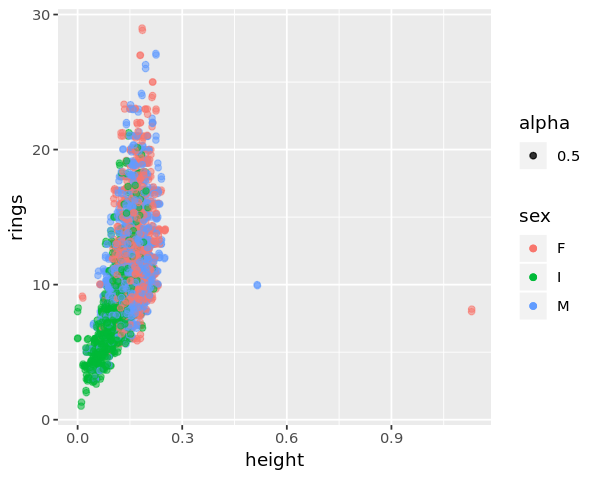

In [16]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 4) 
ggplot(abalone, aes(x = height, y = rings, color = sex, alpha=0.5)) + geom_point() + geom_jitter()

In [17]:
# Do OneHotEncoding for Sex column
library(dplyr)

abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
15,0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
7,0,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
9,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
10,0,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
7,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
8,0,0,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120


Now let's write the dataframe to a CSV file locally on the SageMaker instance.

In [18]:
write_csv(abalone, 'abalone.csv', col_names = TRUE)

Then, upload the csv file to the Amazon S3 default bucket into the `data` key:

In [24]:
s3_train <- session$upload_data(path = 'abalone.csv', 
                                bucket = bucket, 
                                key_prefix = 'r_hello_world_demo/data')

s3_path = paste('s3://',bucket,'/r_hello_world_demo/data/abalone.csv',sep = '')
cat('Your CSV data is stored on S3 in this location:\n',s3_path)

Your CSV data is stored on S3 in this location:
 s3://sagemaker-us-east-1-742960031502/r_hello_world_demo/data/abalone.csv

## Extensions
This example walked you through a simple process for setting up your SageMaker environment and write your R script. In addition, you were able to download a dataset, process it, visualize it, and then store it on S3.

If you are interested in learning more about how you can leverage R on SageMaker and take advantage of SageMaker features for training, tuning, and deploying machine learning models, visit other exampls in this GitHub repository:

https://github.com/awslabs/amazon-sagemaker-examples/tree/master/r_examples